In [1]:
import pandas as pd
import numpy as np

In [2]:
#def rename_columns(path = "data/cifar10_cons.csv"):
def OSL_data_old(path = "data/exp2/IMDBtoken_pos2_val.csv"):
   df = pd.read_csv(path)
   df = df.drop(["Step"], axis='columns')
   print(df.shape)
   min_max = [col for col in list(df.columns) if "MIN" in col or "MAX" in col]
   df = df.drop(min_max, axis='columns')
   print(df.shape)

   not_all = [col for col in list(df.columns) if "\'first\'" in col or "\'everyother\'"  in col]
   print("not all", not_all)
   df = df.drop(not_all, axis='columns')
   df = df.dropna(axis = "columns")
   df = df.rename(columns={name: name.lower()[:-11] for name in list(df.columns)})

   imdb = True if "IMDB" in path else False
   vars = ["mamba", "diag","10000", "1024", "true"]
   bonus_vars = ["b", "c", "dt", "x"]
   final_vars = ["nopos", "imdb","acc"]
   all_vars = vars + bonus_vars + final_vars
   num_vars = len(all_vars)
   old_names = list(df.columns)


   binary_data = np.zeros((len(df.columns), num_vars))
   for name_dix, name in enumerate(old_names):
      for var_idx, var in enumerate(vars):
         if var in name:
            binary_data[name_dix, var_idx] = 1.

         # get b,c,dt,x for s6
         if "s6" in name and "[" in name:
            subset = name.split(" ")[-1]
            for var_idx2, var in enumerate(bonus_vars):
               if var in subset:
                  binary_data[name_dix, len(vars) + var_idx2] = 1.

      # get acc and dataset
      acc = df[name].values[-1]
      binary_data[name_dix, -1] = acc
      if imdb:
         binary_data[name_dix, -2] = 1.

      if len(name.split(" ")) < 3 or not " " in name:
         binary_data[name_dix, -3] = 1.

   return binary_data, all_vars
# imdb_ols_data, all_vars = OSL_data(path="data/exp2/IMDBtoken_pos2_val.csv")
# cifar10_ols_data, _ = OSL_data(path = "data/exp2/CIFAR10cons_pos2_val.csv")

In [3]:
# #def rename_columns(path = "data/cifar10_cons.csv"):
# import pandas as pd
# import numpy as np
# def OSL_data(path="data/exp2/IMDBtoken_pos2_val.csv", test_or_val = "test"):
#    #"test acc","train acc","val acc"
#    df = pd.read_csv(path)
#    print(df.shape)
# 
#    names = list(df["Name"])
# 
#    not_all = [idx for idx, name in enumerate(names) if "\'first\'" in name or "\'everyother\'" in name]
#    print("not all", not_all)
#    assert len(not_all) == 0, "there are fist and everyother"
# 
#    df = df[df.State == "finished"]
#    # df = df.rename(columns={name: name.lower()[:-11] for name in list(df.columns)})
# 
#    names = [name.lower() for name in list(df["Name"])]
#    imdb = True if "IMDB" in path else False
#    vars = ["mamba", "diag", "10000", "1024", "true"]
#    bonus_vars = ["b", "c", "dt", "x"]
#    final_vars = ["imdb", "acc"]
#    all_vars = vars + bonus_vars + final_vars
#    num_vars = len(all_vars)
#    # old_names = list(df.columns)
# 
#    binary_data = np.zeros((len(names), num_vars))
#    for name_dix, name in enumerate(names):
#       for var_idx, var in enumerate(vars):
#          if var in name:
#             binary_data[name_dix, var_idx] = 1.
# 
#          # get b,c,dt,x for s6
#          if "s6" in name and "[" in name:
#             subset = name.split(" ")[-1]
#             for var_idx2, var in enumerate(bonus_vars):
#                if var in subset:
#                   binary_data[name_dix, len(vars) + var_idx2] = 1.
# 
#       # get acc and dataset
#       acc = df[test_or_val+" acc"].values[-1]
#       binary_data[name_dix, -1] = acc
#       if imdb:
#          binary_data[name_dix, -2] = 1.
# 
#       # if len(name.split(" ")) < 3 or not " " in name:
#       #    binary_data[name_dix, -3] = 1.
# 
#    return binary_data, all_vars
# 
# 
# imdb_ols_data, all_vars = OSL_data(path="data/exp2/IMDBtoken_pos2_val.csv")
# cifar10_ols_data, _ = OSL_data(path = "data/exp2/CIFAR10cons_pos2_val.csv")
# 


In [4]:
# imdb_ols_data, all_vars = OSL_data_old(path="data/exp2/IMDBtoken_pos2_val_OLD.csv")
# cifar10_ols_data, _ = OSL_data_old(path = "data/exp2/CIFAR10cons_pos2_val_OLD.csv")
# print(all_vars)

(15, 117)
(15, 39)
not all []
(25, 123)
(25, 41)
not all []
['mamba', 'diag', '10000', '1024', 'true', 'b', 'c', 'dt', 'x', 'nopos', 'imdb', 'acc']


In [64]:
#print(list(zip(all_vars, imdb_ols_data.mean(axis=0))))

imdb_ols_data, all_vars = OSL_data_old(path="data/exp2/IMDBtoken_pos2_val_OLD.csv")
cifar10_ols_data, _ = OSL_data_old(path = "data/exp2/CIFAR10cons_pos2_val_OLD.csv")


print("cifar", cifar10_ols_data.mean(axis=0).round(2))
print("imdb", imdb_ols_data.mean(axis=0).round(2))
combined = np.vstack((cifar10_ols_data, imdb_ols_data))


no_pos_ = True
if no_pos_:
   combined = np.delete(combined, -3, axis=1)
   all_vars.pop(-3)

print(all_vars)
print("combined", combined.mean(axis=0).round(2))
print("combined shape:", combined.shape)
#print(cifar10_ols_data.round(2))

(15, 117)
(15, 39)
not all []
(25, 123)
(25, 41)
not all []
cifar [0.71 0.59 0.44 0.56 0.44 0.29 0.27 0.27 0.2  0.07 0.   0.76]
imdb [0.77 0.46 0.44 0.56 0.38 0.33 0.33 0.26 0.21 0.1  1.   0.79]
['mamba', 'diag', '10000', '1024', 'true', 'b', 'c', 'dt', 'x', 'imdb', 'acc']
combined [0.74 0.52 0.44 0.56 0.41 0.31 0.3  0.26 0.2  0.49 0.78]
combined shape: (80, 11)


In [65]:
combined

array([[0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.77019995],
       [0.        , 1.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.73719996],
       [0.        , 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.81199998],
       [0.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.74199998],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.67739999],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.7008    ],
       [1.        , 0.        , 0.        , 0.        , 1.

In [66]:
import statsmodels.api as sm
y = combined[:,-1]
x = combined[:,:-1]
x = sm.add_constant(x, has_constant="raise")
mod = sm.OLS(y,x)
fit = mod.fit()
print(fit.params)
fit.summary(xname=["cons"]+all_vars[:-1])


[ 7.57834095e-01  4.92942834e-02 -4.91077736e-02  1.26571815e-02
  5.25031172e-02 -3.69766624e-02 -1.43352172e-02 -7.11750703e-04
 -2.43882682e-02 -4.02680364e-02  1.89012373e-02]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     7.249
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.04e-07
Time:                        16:37:50   Log-Likelihood:                 139.17
No. Observations:                  80   AIC:                            -256.3
Df Residuals:                      69   BIC:                            -230.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons           0.7578      0.023     32.309      0.000       0.711       0.805
mamba          0.0493      0.014      3.492      0.001       0.021       0.077
diag          -0.0491      0.021     -2.388      0.020      -0.090      -0.008
10000          0.0127      0.011      1.157      0.251      -0.009       0.034
1024           0.0525      0.011      4.679      0.000       0.030       0.075
true          -0.0370      0.011     -3.335      0.001      -0.059      -0.015
b             -0.0143      0.024     -0.589      0.558      -0.063       0.034
c             -0.0007      0.023     -0.031      0.975      -0.046       0.045
dt            -0.0244      0.017     -1.473      0.145      -0.057       0.009
x             -0.0403      0.016     -2.526      0.014      -0.072      -0.008
imdb           0.0189      0.010      1.809      0.075      -0.002       0.040
==============================================================================
Omnibus:                        1.858   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                1.831
Skew:                          -0.299   Prob(JB):                        0.400
Kurtosis:                       2.561   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
all_vars

['mamba', 'diag', '10000', '1024', 'true', 'b', 'c', 'dt', 'x', 'imdb', 'acc']

[0, 1, 9]
old names ['mamba', 'diag', '10000', '1024', 'true', 'b', 'c', 'dt', 'x', 'imdb', 'acc']
new names ['Mamba' 's4d' '10000' 'Norm' 'Train' 'b' 'c' 'dt' 'x' 'IMDB']
[2, 3, 4, 5, 6, 7, 8]
old names ['mamba', 'diag', '10000', '1024', 'true', 'b', 'c', 'dt', 'x', 'imdb', 'acc']
new names ['Mamba' 's4d' '10000' 'Norm' 'Train' 'b' 'c' 'dt' 'x' 'IMDB']


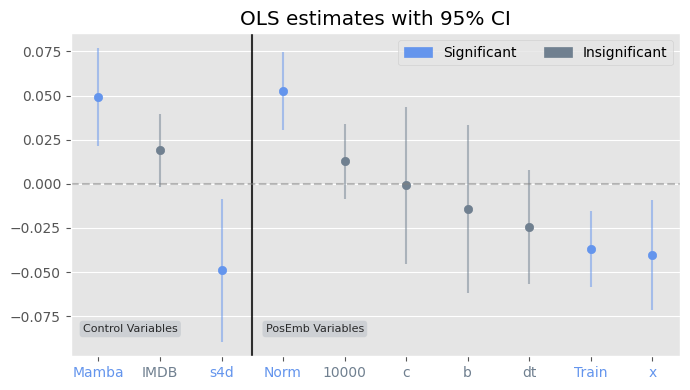

In [75]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
num_vars = len(fit.params[1:])


params_ = np.array(fit.params[1:])
if no_pos_:
   all_vars_ = np.array(["Mamba", "s4d", "10000", "Norm", "Train", "b", "c", "dt", "x","IMDB"])
else:
   all_vars_ = np.array(["Mamba", "s4d", "10000", "Norm", "Train", "b", "c", "dt", "x", "NoPos","IMDB"])#np.array(all_vars[:-1])
not_pos_vars_idx = [0,1,len(params_)-1]
tmp = ((0,not_pos_vars_idx), 
       (len(not_pos_vars_idx), [idx for idx in list(range(len(params_))) if idx not in not_pos_vars_idx]))
plt.figure(figsize=(7,4))    
#xtick_idx = []
colors = [] 
for off_set, range_ in tmp:
   print(range_)
   print("old names", all_vars)
   print("new names",all_vars_)
   se_ = np.array(fit.bse[1:])[range_]
   sorted_args = np.argsort(params_[range_])[::-1]
   # print(sorted_args)
   # print(params_)
   
   params = params_[range_][sorted_args]
   se = se_[sorted_args]
   all_var_names = all_vars_[range_][sorted_args]
   
   
   ax = plt.subplot(111)
   for i in range(len(range_)):
      if ((params[i]-1.96*se[i] < 0) and  (params[i]+1.96*se[i] < 0))  or ((params[i]-1.96*se[i] > 0) and  (params[i]+1.96*se[i] > 0)):
         color="cornflowerblue"
         alpha=1.
      else:
         color="slategray"
         alpha=0.6
      colors.append(color)
      #xtick_idx.append(i+off_set)
      plt.scatter(i+off_set, params[i], color=color)
      plt.vlines(i+off_set, params[i]-1.96*se[i], params[i]+1.96*se[i], color=color, alpha=0.5)

plt.xticks(range(num_vars), np.concatenate((np.array(["Mamba", "IMDB", "s4d"]), all_var_names)))
xticks = [tick for tick in ax.get_xticklabels()]

for ax_, color in zip(ax.get_xticklabels(), colors):
    ax_.set_color(color)

import matplotlib.patches as mpatches
red_patch = [
           mpatches.Patch(color='cornflowerblue', label='Significant'),
           mpatches.Patch(color='slategray', label='Insignificant'),
          ]

plt.legend(handles=red_patch, ncol=2)

plt.axvline(2.5,color="black", alpha=0.8)
plt.axhline(0, color="gray", alpha=0.5, linestyle="--")
plt.grid(axis="x")
plt.title("OLS estimates with 95% CI")
plt.tight_layout()

props = dict(boxstyle='round', facecolor='slategray', alpha=0.2)
ctr_vars = "Control Variables"
ax.text(0.02, 0.1, ctr_vars, transform=ax.transAxes, fontsize=8,color="black", alpha=0.8,
        verticalalignment='top', bbox=props)
indent = 0.3
ctr_vars = "PosEmb Variables"
if no_pos_:
   indent+=0.02
ax.text(indent,0.1, ctr_vars, transform=ax.transAxes, fontsize=8, color="black", alpha=0.8,
        verticalalignment='top', bbox=props)


plt.savefig(f"data/exp2/ols_coef_ci_pos_emb.png", dpi=200)


In [9]:
all_vars__ = np.array(["Mam", "s4d", "10000", "Norm", "Train", "b", "c", "dt", "x", "NoPos", "IMDB", "Acc"])

df = np.vstack((np.array(all_vars__), 
                imdb_ols_data.sum(axis=0).astype(int), 
                cifar10_ols_data.sum(axis=0).astype(int),
                combined.sum(axis=0).astype(int), 
                combined.mean(axis=0).round(3))) 
df

array([['Mam', 's4d', '10000', 'Norm', 'Train', 'b', 'c', 'dt', 'x',
        'NoPos', 'IMDB', 'Acc'],
       ['30', '18', '17', '22', '15', '13', '13', '10', '8', '4', '39',
        '30'],
       ['29', '24', '18', '23', '18', '12', '11', '11', '8', '3', '0',
        '31'],
       ['59', '42', '35', '45', '33', '25', '24', '21', '16', '7', '39',
        '62'],
       ['0.738', '0.525', '0.438', '0.562', '0.412', '0.312', '0.3',
        '0.262', '0.2', '0.088', '0.488', '0.778']], dtype='<U32')

In [10]:
df[1,-1] = imdb_ols_data.mean(axis=0).round(3)[-1]
df[2,-1] = cifar10_ols_data.mean(axis=0).round(3)[-1]
df[3,-1] = None
df

array([['Mam', 's4d', '10000', 'Norm', 'Train', 'b', 'c', 'dt', 'x',
        'NoPos', 'IMDB', 'Acc'],
       ['30', '18', '17', '22', '15', '13', '13', '10', '8', '4', '39',
        '0.793'],
       ['29', '24', '18', '23', '18', '12', '11', '11', '8', '3', '0',
        '0.764'],
       ['59', '42', '35', '45', '33', '25', '24', '21', '16', '7', '39',
        'None'],
       ['0.738', '0.525', '0.438', '0.562', '0.412', '0.312', '0.3',
        '0.262', '0.2', '0.088', '0.488', '0.778']], dtype='<U32')